# Plotting

In [1]:
import numpy as np
import xarray as xr
import proplot as pplt
import s2stools
import matplotlib.pyplot as plt

/project/meteo/work/Jonas.Spaeth/gitprojects/strat-impact-on-forecast-uncertainty/venv/lib/python3.11/site-packages/s2stools/clim.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import warnings

warnings.filterwarnings("ignore")

## Fig. 1

In [3]:
data_fig1 = xr.open_dataset(
    "../data/processed/for-plotting/fig1_z1000_mean_variance_by_vortex.nc"
)
data_fig1

<xarray.Dataset>
Dimensions:         (u_bins: 2, latitude: 37, longitude: 144)
Coordinates:
  * longitude       (longitude) float32 -180.0 -177.5 -175.0 ... 175.0 177.5
  * latitude        (latitude) float32 0.0 2.5 5.0 7.5 ... 82.5 85.0 87.5 90.0
  * u_bins          (u_bins) <U27 'Weak initial polar vortex' 'Strong initial...
Data variables:
    z1000_anom      (u_bins, latitude, longitude) float32 ...
    z1000_var_anom  (u_bins, latitude, longitude) float32 ...

In [4]:
def plot_anom_z1000(
    z1000ensspreadanom_toplot,
    z1000ensmeananom_toplot,
    contourf_kws={},
    contour_kws={},
    ax=None,
):
    if ax is None:
        fig, ax = pplt.subplots(proj="npstere", boundinglat=30, refheight=1.5)
    else:
        fig = plt.gcf()

    contourf_kws = (
        dict(
            colorbar="r",
            cmap_kw=dict(cut=-0.05),
            colorbar_kw=dict(title="gpm$^2$"),
            levels=np.arange(-3000, 3001, 500),
            cmap="cmap",
            extend=("both"),
        )
        | contourf_kws
    )

    contour_kws = (
        dict(
            levels=np.arange(-15 * 10, 15 * 10 + 1, 10),
            diverging=True,
            color="k",
            nozero=True,
            labels=True,
            labels_kw=dict(weight="normal", fontsize=8),
            lw=1,
        )
        | contour_kws
    )

    p1 = ax.contourf(
        *s2stools.plot.cyclic_xyz(z1000ensspreadanom_toplot),
        **contourf_kws,
    )
    p2 = ax.contour(
        *s2stools.plot.cyclic_xyz(z1000ensmeananom_toplot),
        **contour_kws,
    )
    return fig, ax, (p1, p2)


def add_map(ax, **kwargs):
    default_kwargs = dict(
        coast=True,
        land=True,
        landcolor="gray1",
        landalpha=0.2,
        landzorder=-100,
        coastcolor="gray7",
        coastlinewidth=0.4,
        coastzorder=100,
    )
    plotting_kwargs = default_kwargs | kwargs
    ax.format(**plotting_kwargs)


cmap = pplt.Colormap("Blues5_r", (1, 1, 1, 0), "Reds2", ratios=[3, 1, 3], name="cmap")
cmap = pplt.Colormap(
    "Blues5_r", (1, 1, 1, 0), "Reds2", ratios=[3, 1, 3], name="cmap_opaque"
)

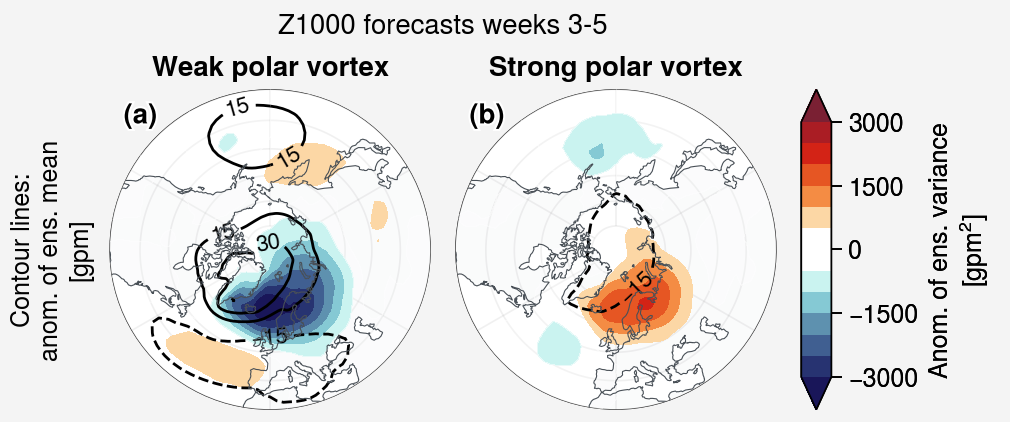

In [5]:
fig, axs = pplt.subplots(ncols=2, proj="npstere", boundinglat=30, refheight=1.6)

LEVELS = np.arange(-3000, 3000 + 1, 500)

CONTOURF_KWS = dict(
    levels=LEVELS, colorbar=False, cmap_kw=dict(cut=-0.06), cmap="cmap_opaque", zorder=4
)
CONTOUR_KWS = dict(levels=np.arange(-60, 61 + 1, 15), zorder=5)


_ = plot_anom_z1000(
    z1000ensspreadanom_toplot=data_fig1.sel(
        u_bins="Weak initial polar vortex",
    ).z1000_var_anom,
    z1000ensmeananom_toplot=data_fig1.sel(
        u_bins="Weak initial polar vortex",
    ).z1000_anom,
    contourf_kws=CONTOURF_KWS,
    contour_kws=CONTOUR_KWS,
    ax=axs[0],
)

_, _, plots = plot_anom_z1000(
    z1000ensspreadanom_toplot=data_fig1.sel(
        u_bins="Strong initial polar vortex",
    ).z1000_var_anom,
    z1000ensmeananom_toplot=data_fig1.sel(
        u_bins="Strong initial polar vortex",
    ).z1000_anom,
    contourf_kws=CONTOURF_KWS,
    contour_kws=CONTOUR_KWS,
    ax=axs[1],
)

axs[0].format(title=f"Weak polar vortex", title_kw=dict(weight="bold"))
axs[1].format(title=f"Strong polar vortex", title_kw=dict(weight="bold"))

textlabel = "Contour lines:\nanom. of ens. mean\n[gpm]"
axs[0].text(
    -0.18,
    0.5,
    textlabel,
    va="center",
    ha="center",
    weight="normal",
    rotation=90,
    transform="axes",
)

add_map(axs, landzorder=1, landalpha=0.5)

fig.colorbar(
    plots[0],
    # cols=[1, 2],
    loc="r",
    title="Anom. of ens. variance\n[gpm$^2$]",
    width=0.15,
    locator=1500,
)

fig.format(
    lw=0.25,
    suptitle="Z1000 forecasts weeks 3-5",
    suptitle_kw=dict(weight="normal"),
    abc="(a)",
    abcloc="ul",
)

## Fig. 2

In [6]:
data_fig2_uv = xr.open_dataset("../data/processed/for-plotting/fig2_u_and_v.nc")
data_fig2_eddy_activity = xr.open_dataset(
    "../data/processed/for-plotting/fig2_eddy_activity.nc"
)
data_fig2_uv_clim = xr.open_dataset("../data/processed/for-plotting/fig2_clim_uv.nc")
data_fig2_pv_clim = xr.open_dataset("../data/processed/for-plotting/fig2_clim_pv.nc")

In [7]:
def plot_anom_uv850(
    ensspreadanom_toplot,
    wind_anomalies_to_plot,
    contourf_kw=dict(),
    quiver_kw=dict(),
    ax=None,
):
    if ax is None:
        fig, ax = pplt.subplots(
            ncols=1,
            proj="npstere",
            boundinglat=20,
            refwidth=3,
        )
    else:
        fig = plt.gcf()

    wind_anomalies_to_plot = wind_anomalies_to_plot.coarsen(
        longitude=4, latitude=2, boundary="pad"
    ).mean()
    wind_anomalies_to_plot = (
        wind_anomalies_to_plot.assign_coords(
            longitude=(((wind_anomalies_to_plot.longitude + 180) % 360) - 180)
        )
        .sortby("longitude")
        .sortby("latitude")
    )

    # plotting

    # anomalies
    quiver_kw = (
        dict(
            scale=30,
            zorder=100,
            width=0.003,
            alpha=1,
            color="k",
            headwidth=7,
        )
        | quiver_kw
    )
    p1 = ax.quiver(wind_anomalies_to_plot.u, wind_anomalies_to_plot.v, **quiver_kw)

    # anomalous ensemble spread

    contourf_kw = (
        dict(
            cmap="cmap",
            cmap_kw=dict(cut=-0.07),
            colorbar="r",
            colorbar_kw=dict(title="$\sigma$ (u component)", width=0.15),
            extend=("both"),
            zorder=-20,
        )
        | contourf_kw
    )

    p2 = ax.contourf(*s2stools.plot.cyclic_xyz(ensspreadanom_toplot), **contourf_kw)

    return fig, ax, (p1, p2)


def plot_anom_uv200(wind_anomalies_to_plot, quiver_kw=dict(), ax=None):
    if ax is None:
        fig, ax = pplt.subplots(proj="npstere", boundinglat=30, refheight=3)
    else:
        fig = plt.gcf()

    wind_anomalies_to_plot = wind_anomalies_to_plot.coarsen(
        longitude=4, latitude=2, boundary="pad"
    ).mean()

    # anomalies
    quiver_kw = (
        dict(
            zorder=100,
            width=0.003,
            alpha=1,
            color="k",
            headwidth=7,
        )
        | quiver_kw
    )
    p1 = ax.quiver(wind_anomalies_to_plot.u, wind_anomalies_to_plot.v, **quiver_kw)

    return fig, ax, (p1,)


def plot_anom_pv320(toplot_pvvar, contourf_kw=dict(), ax=None):
    if ax is None:
        fig, ax = pplt.subplots(proj="npstere", boundinglat=30, refheight=1.5)
    else:
        fig = plt.gcf()

    toplot_pvvar = toplot_pvvar * 1e12

    contourf_kw = (
        dict(
            cmap="Div",
            cmap_kw=dict(cut=-0.1),
            extend="both",
            colorbar="b",
            colorbar_kw=dict(width=0.15, title="$(q^{\prime})^2$ anomaly"),
            levels=20,
            vmin=-0.5,
            vmax=0.5,
        )
        | contourf_kw
    )
    p1 = ax.contourf(*s2stools.plot.cyclic_xyz(toplot_pvvar), **contourf_kw)

    toplot = data_fig2_pv_clim.pv_grad_lat.mean("leadtime")
    p2 = ax.plot(toplot, c="bright green")

    return fig, ax, (p1, p2)


def plot_clim_uv850(streamplot_kw=dict(), ax=None):
    if ax is None:
        fig, ax = pplt.subplots(
            proj="nsper",
            proj_kw=dict(lon_0=-20, lat_0=30),
            lonlim=(-80, 10),
            latlim=(20, 90),
            refwidth=1.5,
        )
    else:
        fig = plt.gcf()

    toplot = (
        data_fig2_uv_clim.coarsen(longitude=3, latitude=3, boundary="trim")
        .mean()
        .sel(level=850)
    )

    streamplot_kw = (
        dict(
            cmap="fire_r",
            lw=0.8,
            density=1.5,
            colorbar="b",
            colorbar_kw=dict(title="wind speed [m/s]", locator=4),
        )
        | streamplot_kw
    )

    p1 = ax.streamplot(
        toplot.longitude,
        toplot.latitude,
        toplot.u,
        toplot.v,
        c=np.sqrt(toplot.u**2 + toplot.v**2),
        **streamplot_kw,
    )
    return fig, ax, (p1)


def plot_clim_pv320(ax=None):
    if ax is None:
        fig, ax = pplt.subplots(proj="npstere", boundinglat=20)
    else:
        fig = plt.gcf()

    toplot = (
        np.sqrt(
            data_fig2_pv_clim.pv_var_ensmean.dropna("longitude", how="all").dropna(
                "latitude"
            )
        )
        / 1e-6
    )

    p1 = ax.contourf(
        *s2stools.plot.cyclic_xyz(toplot),
        cmap="fire_r",
        robust=True,
        levels=14,
        extend="both",
    )
    ax.colorbar(p1, loc="b", title="Square-root of enstrophy [PVU]")
    ax.format(land=True, landcolor="gray2", landalpha=0, coast=True)

    toplot = data_fig2_pv_clim.pv_grad_lat.mean("leadtime")
    p2 = ax.plot(toplot, c="bright green")

    return fig, ax, (p1, p2)


TIME_SLICE = slice("14D", "34D")

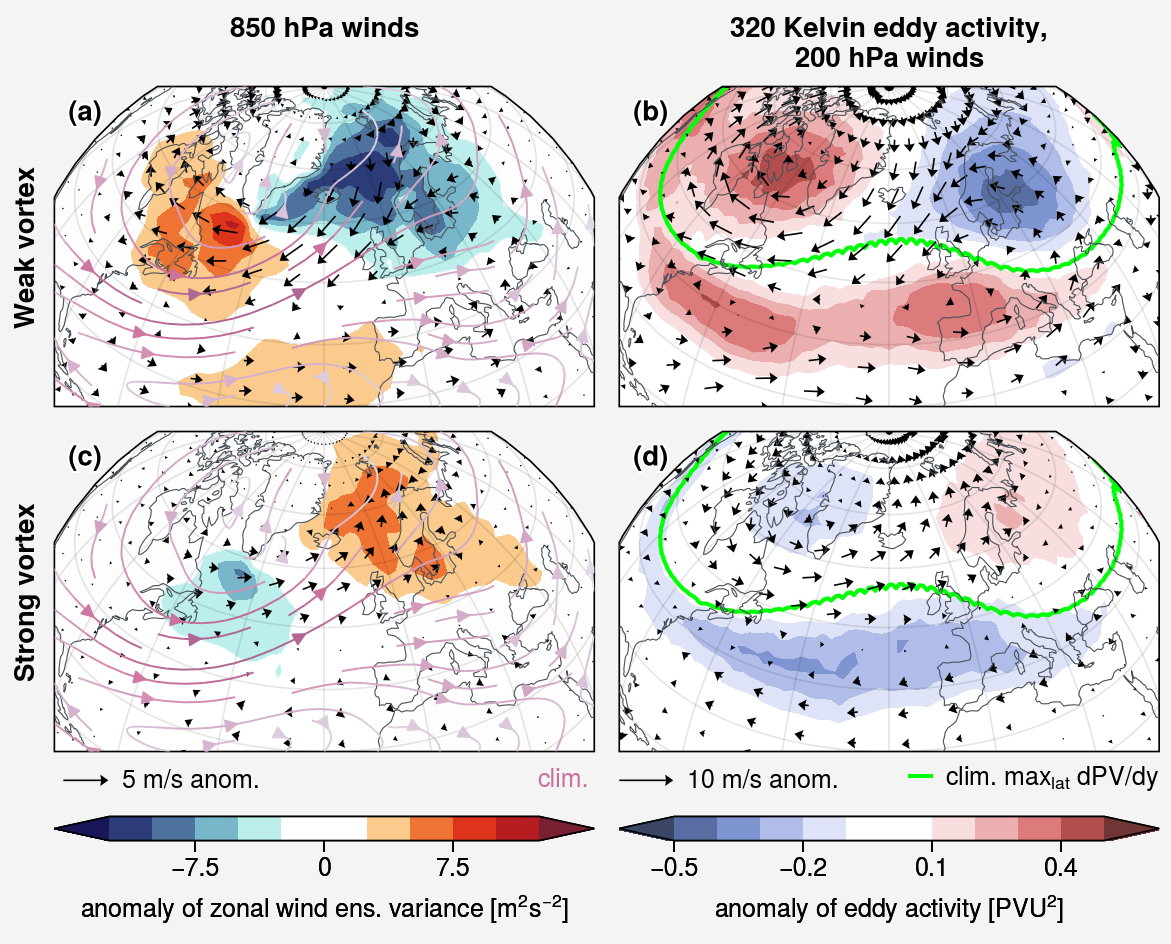

In [8]:
fig, axs = pplt.subplots(
    ncols=2,
    nrows=2,
    proj="nsper",
    proj_kw={"lon_0": -20, "lat_0": 40},
    latlim=(30, 90),
    lonlim=(-90, 50),
    refheight=1.6,
    reso="lo",
)


LEVELS = np.arange(-12.5, 12.5 + 1e-5, 2.5)
QUIVER_KW = dict(scale=60)
CONTOURF_KW = dict(colorbar=False, cmap_kw=dict(cut=-0.08), levels=LEVELS)

_, _, plots1a = plot_anom_uv850(
    ensspreadanom_toplot=data_fig2_uv.sel(
        u_bins="Weak initial polar vortex", level=850
    ).u_ensvar_anom.squeeze(drop=True),
    wind_anomalies_to_plot=data_fig2_uv.sel(
        u_bins="Weak initial polar vortex",
    ).sel(
        level=850
    )[["u", "v"]],
    contourf_kw=CONTOURF_KW,
    quiver_kw=QUIVER_KW,
    ax=axs[0, 0],
)

_, _, plots1b = plot_anom_uv850(
    ensspreadanom_toplot=data_fig2_uv.sel(
        u_bins="Strong initial polar vortex", level=850
    ).u_ensvar_anom.squeeze(drop=True),
    wind_anomalies_to_plot=data_fig2_uv.sel(
        u_bins="Strong initial polar vortex",
    ).sel(
        level=850
    )[["u", "v"]],
    ax=axs[1, 0],
    contourf_kw=CONTOURF_KW,
    quiver_kw=QUIVER_KW,
)

for ax in axs[:, 0]:
    streamplot_kw = dict(
        cmap="acton_r",
        cmap_kw=dict(right=0.9),
        lw=0.7,
        colorbar=False,
        density=0.5,
        zorder=200,
        colorbar_kw=dict(locator=4, shrink=10, width=1, labelloc="bottom", title=""),
    )
    plot_clim_uv850(ax=ax, streamplot_kw=streamplot_kw)

# *****************************************************************

LEVELS = np.arange(-1, 1, 0.25)
LEVELS = np.arange(-0.5, 0.5 + 1e-4, 0.1)

_, _, plots2a = plot_anom_pv320(
    data_fig2_eddy_activity.eddy_activity.sel(
        u_bins="Weak initial polar vortex",
        leadtime=TIME_SLICE,
    ).mean("leadtime"),
    contourf_kw=dict(colorbar=False, levels=LEVELS),
    ax=axs[0, 1],
)
_, _, plots2b = plot_anom_pv320(
    data_fig2_eddy_activity.eddy_activity.sel(
        u_bins="Strong initial polar vortex",
        leadtime=TIME_SLICE,
    ).mean("leadtime"),
    contourf_kw=dict(colorbar=False, levels=LEVELS),
    ax=axs[1, 1],
)
# *****************************************************************
QUIVER_KW = dict(scale=100)

_, _, plots_uv200_weak = plot_anom_uv200(
    wind_anomalies_to_plot=data_fig2_uv[["u", "v"]].sel(
        level=200, u_bins="Weak initial polar vortex"
    ),
    quiver_kw=QUIVER_KW,
    ax=axs[0, 1],
)

_, _, plots_uv200_strong = plot_anom_uv200(
    wind_anomalies_to_plot=data_fig2_uv[["u", "v"]].sel(
        level=200, u_bins="Strong initial polar vortex"
    ),
    quiver_kw=QUIVER_KW,
    ax=axs[1, 1],
)

# *****************************************************************

add_map(axs)

axs[1, 0].quiverkey(
    plots1b[0],
    0.1,
    -0.09,
    5,
    label="5 m/s anom.",
    labelpos="E",
    coordinates="axes",
    labelsep=0.07,
)
axs[1, 1].quiverkey(
    plots_uv200_strong[0],
    0.1,
    -0.09,
    10,
    label="10 m/s anom.",
    labelpos="E",
    coordinates="axes",
    labelsep=0.07,
)

ax.text(
    0.99,
    -0.09,
    "clim.",
    transform="axes",
    ha="right",
    va="center",
    color=(200 / 256, 113 / 256, 157 / 256),
)

fig.colorbar(
    plots1b[1],
    loc="b",
    cols=[1],
    pad=0.5,
    width=0.12,
    title="anomaly of zonal wind ens. variance [m$^2$s$^{-2}$]",
)

fig.colorbar(
    plots2b[0],
    loc="b",
    cols=[2],
    pad=0.5,
    width=0.12,
    title="anomaly of eddy activity [PVU$^{2}$]",
)

axs[1, 1].legend(
    plots2b[1],
    "clim. max$_{\mathrm{lat}}$ dPV/dy",
    loc="b",
    frameon=False,
    align="right",
    handlelength=1,
)

fig.format(
    leftlabels=["Weak vortex", "Strong vortex"],
    toplabels=["850 hPa winds\n", "320 Kelvin eddy activity,\n200 hPa winds"],
    abc="(a)",
    abcloc="ul",
    abc_kw=dict(zorder=1000),
)

## Fig. 3

In [9]:
data_fig3 = xr.open_dataset(
    "../data/processed/for-plotting/fig3_z1000_mean_variance_by_teleconnection.nc"
)

Weak initial polar vortex - Strong initial polar vortex
El Nino - La Nina
MJO 7,8 - MJO 2,3
QBO E - QBO W


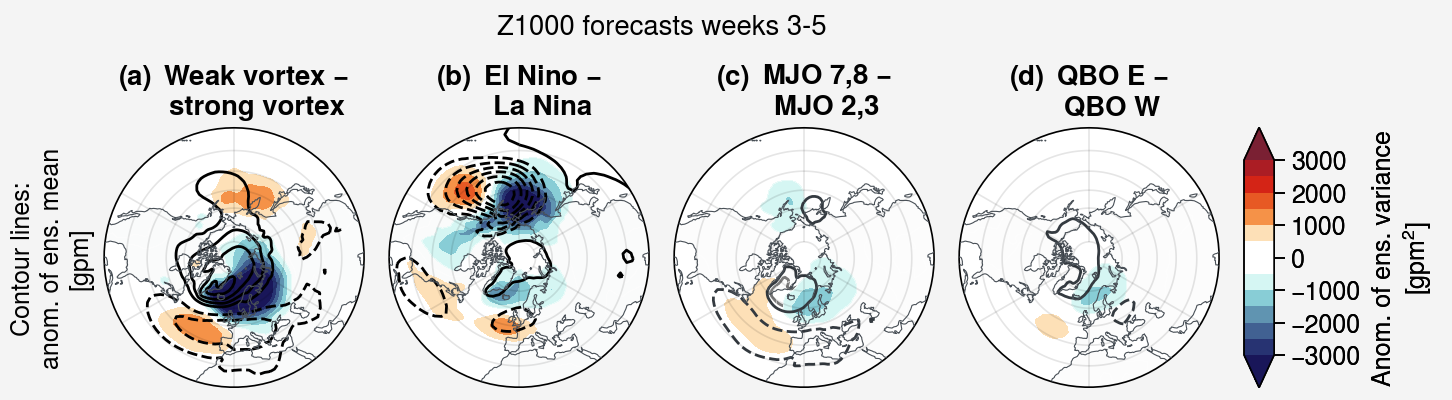

In [10]:
# SETUP

fig, axs = pplt.subplots(
    ncols=4, proj="npstere", boundinglat=20, refheight=1.3, refwidth=1.3
)

add_map(axs, landzorder=0, landalpha=0.5)


LEVELS_CONTOURF = np.arange(-3000, 3000 + 1, 500)
LEVELS_CONTOUR = np.arange(-120, 121, 15)
LEVELS_CONTOUR_ADDITIONAL = np.sort(np.arange(-120, 121, 30).tolist() + [-10, 10])

groups = [
    "Weak initial polar vortex - Strong initial polar vortex",
    "El Nino - La Nina",
    "MJO 7,8 - MJO 2,3",
    "QBO E - QBO W",
]

# PLOT

CONTOURF_KWS = dict(
    levels=LEVELS_CONTOURF, colorbar=False, cmap_kw=dict(cut=-0.08), zorder=1
)
CONTOUR_KWS = dict(levels=LEVELS_CONTOUR, labels=False, lw=1, zorder=1)

for ax, g in zip(axs, groups[:]):
    print(g)
    _, _, (p1, p2) = plot_anom_z1000(
        z1000ensspreadanom_toplot=data_fig3.sel(
            group=g,
        ).z1000_var_anom,
        z1000ensmeananom_toplot=data_fig3.sel(
            group=g,
        ).z1000_anom,
        contourf_kws=CONTOURF_KWS,
        contour_kws=CONTOUR_KWS,
        ax=ax,
    )

# ADDITIONAL GRAY CONTOUR LINE FOR MJO QBO

CONTOURF_KWS = dict(
    levels=LEVELS_CONTOURF, colorbar=False, cmap_kw=dict(cut=-0.08), zorder=1
)
CONTOUR_KWS = dict(
    levels=LEVELS_CONTOUR_ADDITIONAL, labels=False, lw=1, color="gray8", zorder=1
)

for ax, g in zip(axs[2:], groups[2:]):
    _, _, (p1, p2) = plot_anom_z1000(
        z1000ensspreadanom_toplot=data_fig3.sel(
            group=g,
        ).z1000_var_anom,
        z1000ensmeananom_toplot=data_fig3.sel(
            group=g,
        ).z1000_anom,
        contourf_kws=CONTOURF_KWS,
        contour_kws=CONTOUR_KWS,
        ax=ax,
    )

# FORMAT

axs[0].format(title=f"Weak vortex $-$\nstrong vortex", title_kw=dict(weight="bold"))
axs[1].format(title=f"El Nino $-$\nLa Nina", title_kw=dict(weight="bold"))
axs[2].format(title=f"MJO 7,8 $-$\nMJO 2,3", title_kw=dict(weight="bold"))
axs[3].format(title=f"QBO E $-$\nQBO W", title_kw=dict(weight="bold"))

textlabel = "Contour lines:\nanom. of ens. mean\n[gpm]"
axs[0].text(
    -0.2,
    0.5,
    textlabel,
    va="center",
    ha="center",
    weight="normal",
    rotation=90,
    transform="axes",
)


fig.colorbar(
    p1,
    loc="r",
    title="Anom. of ens. variance\n[gpm$^2$]",
    width=0.15,
)

fig.format(
    suptitle="Z1000 forecasts weeks 3-5",
    suptitle_kw=dict(weight="normal"),
    abc="(a)\n",
    abcloc="center",
)